## Data
We obtained data from GDELT. Our SQL query exports filtered data from the **GDELT event database** in BigQuery to Google Cloud Storage (GCS) in **CSV** format. The export includes events that involve actors from three specific countries (**USA**, **India**, and **China**) and limits results to reputable publishers from the **USA**, **UK**, **India**, and **China**. The query filters events occurring between **January 1, 2010**, and **December 31, 2020**.

Data and SQL query location: `countries-in-news/data`

#### Export Details:
- **URI**: The data is exported to `gs://gdelt-storage/gdelt-2024-09-30-*.csv` in Google Cloud Storage. The `*` in the URI allows the export to split into multiple files if needed (BigQuery automatically splits files larger than 1GB).
- **File Format**: The export is in CSV format.
- **Overwrite**: Existing files with the same name in the GCS bucket will be overwritten.
- **Header**: The CSV file includes headers.
- **Field Delimiter**: Fields in the CSV are separated by commas (`,`).

#### Query Breakdown:
1. **SELECT Clause**:
   - **SQLDATE**: The date of the event in the format `YYYYMMDD`.
   - **Actor1CountryCode**: The country code of the first actor involved in the event (e.g., 'USA', 'IND').
   - **Actor2CountryCode**: The country code of the second actor involved in the event.
   - **GoldsteinScale**: A numeric score representing the impact of the event (higher values represent more positive events, lower values represent more negative events).
   - **Actor1Geo_CountryCode**: The country code of the location associated with the first actor.
   - **AvgTone**: The average tone of the event, indicating how positive or negative the media coverage of the event is.
   - **SOURCEURL**: The URL of the news source reporting the event.

2. **FROM Clause**:
   - The data is being pulled from the `gdelt-bq.full.events` table, which contains global event data from the GDELT project.

3. **WHERE Clause**:
   - **Actor1CountryCode Filter**: Only events where the first actor is from the **USA**, **India**, or **China** are included.
   - **SQLDATE Filter**: The query filters events that occurred between **January 1, 2010** (`20100101`) and **December 31, 2020** (`20201231`).
   - **SOURCEURL Filter**: The query restricts events to those reported by the following reputable publishers:
     - **nytimes.com** (The New York Times)
     - **washingtonpost.com** (The Washington Post)
     - **cnn.com** (CNN)
     - **bbc.com** (BBC, United Kingdom)
     - **thehindu.com** (The Hindu, India)
     - **xinhuanet.com** (Xinhua News, China)

4. **ORDER BY Clause**:
   - The results are ordered by `SQLDATE` in descending order, meaning the most recent events are listed first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [54]:
# Read each CSV file and concatenate them into one DataFrame
df = pd.read_csv('gdelt.csv')
df

,SQLDATE,Actor1CountryCode,GoldsteinScale,Actor1Geo_CountryCode,AvgTone,SOURCEURL,YEAR,MONTH,DAY,Source
0,2015-08-14,IND,-4.0,IN,-1.546135,http://www.thehindu.com/news/national/indias-d...,2015,8,14,thehindu.com
1,2015-08-14,USA,4.0,US,3.020134,http://www.nytimes.com/2015/08/14/arts/music/c...,2015,8,14,nytimes.com
2,2015-08-14,USA,3.4,US,-0.496278,http://www.washingtonpost.com/news/the-fix/wp/...,2015,8,14,washingtonpost.com
3,2015-08-14,USA,-2.0,US,-4.839956,http://www.nytimes.com/aponline/2015/08/14/us/...,2015,8,14,nytimes.com
4,2015-08-14,USA,-10.0,US,-2.046649,http://www.nytimes.com/politics/first-draft/20...,2015,8,14,nytimes.com
...,...,...,...,...,...,...,...,...,...,...
1868061,2015-08-15,IND,7.0,IN,-1.117318,http://timesofindia.indiatimes.com/city/mysuru...,2015,8,15,indiatimes.com
1868062,2015-08-15,IND,1.9,IN,-7.782101,http://www.thehindu.com/news/cities/Delhi/man-...,2015,8,15,thehindu.com
1868063,2015-08-15,IND,0.0,IN,-1.419745,http://timesofindia.indiatimes.com/city/amrits...,2015,8,15,indiatimes.com
1868064,2015-08-15,USA,1.9,US,-3.037762,http://www.nytimes.com/2015/08/16/us/politics/...,2015,8,15,nytimes.com


In [55]:
# use year month and day columns to create a new column called SQLDATE in datetime format
df['SQLDATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df

,SQLDATE,Actor1CountryCode,GoldsteinScale,Actor1Geo_CountryCode,AvgTone,SOURCEURL,YEAR,MONTH,DAY,Source
0,2015-08-14,IND,-4.0,IN,-1.546135,http://www.thehindu.com/news/national/indias-d...,2015,8,14,thehindu.com
1,2015-08-14,USA,4.0,US,3.020134,http://www.nytimes.com/2015/08/14/arts/music/c...,2015,8,14,nytimes.com
2,2015-08-14,USA,3.4,US,-0.496278,http://www.washingtonpost.com/news/the-fix/wp/...,2015,8,14,washingtonpost.com
3,2015-08-14,USA,-2.0,US,-4.839956,http://www.nytimes.com/aponline/2015/08/14/us/...,2015,8,14,nytimes.com
4,2015-08-14,USA,-10.0,US,-2.046649,http://www.nytimes.com/politics/first-draft/20...,2015,8,14,nytimes.com
...,...,...,...,...,...,...,...,...,...,...
1868061,2015-08-15,IND,7.0,IN,-1.117318,http://timesofindia.indiatimes.com/city/mysuru...,2015,8,15,indiatimes.com
1868062,2015-08-15,IND,1.9,IN,-7.782101,http://www.thehindu.com/news/cities/Delhi/man-...,2015,8,15,thehindu.com
1868063,2015-08-15,IND,0.0,IN,-1.419745,http://timesofindia.indiatimes.com/city/amrits...,2015,8,15,indiatimes.com
1868064,2015-08-15,USA,1.9,US,-3.037762,http://www.nytimes.com/2015/08/16/us/politics/...,2015,8,15,nytimes.com


In [56]:
df['YEAR'] = df['SQLDATE'].dt.year
df['MONTH'] = df['SQLDATE'].dt.month
df['DAY'] = df['SQLDATE'].dt.day

In [60]:
print((df['YEAR']<2013).sum())
print((df['SOURCEURL'].str.contains('sglinks.com')).sum())

0
9


In [61]:
# set df to only include data from 2013 onwards
df = df[df['YEAR']>=2013]
# set df to only include data that does not contain sglinks.com
df = df[~df['SOURCEURL'].str.contains('sglinks.com')]

## Frequency Table

In [63]:
df['Actor1CountryCode'].value_counts()

Actor1CountryCode
USA    1031976
IND     459951
CHN     374078
Name: count, dtype: int64

In [65]:
# Function to extract main domain from the URL (ignoring subdomains)
def extract_main_domain(url):
    # Parse the URL to extract the netloc (domain)
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    
    # If domain is empty, return None (handle poorly formatted URLs)
    if not domain:
        return None

    # Use regex to clean and extract just the main domain, ignoring subdomains
    main_domain = re.search(r'([a-zA-Z0-9-]+\.[a-zA-Z]{2,})$', domain)
    if main_domain:
        return main_domain.group(1)  # Return the main domain (e.g., 'nytimes.com')
    
    return None

In [66]:
df['Source'].value_counts()

Source
washingtonpost.com    543293
indiatimes.com        370990
nytimes.com           291369
thehindu.com          251902
xinhuanet.com         224039
scmp.com              147759
bbc.com                36653
Name: count, dtype: int64

In [67]:
df_plot = df.groupby(['Actor1CountryCode', 'Source'])[['Actor1CountryCode', 'Source']].value_counts().reset_index()
df_plot.columns = ['Actor1CountryCode', 'Source', 'Articles']
df_plot

,Actor1CountryCode,Source,Articles
0,CHN,bbc.com,6669
1,CHN,indiatimes.com,27911
2,CHN,nytimes.com,27516
3,CHN,scmp.com,101321
4,CHN,thehindu.com,22945
5,CHN,washingtonpost.com,28003
6,CHN,xinhuanet.com,159713
7,IND,bbc.com,925
8,IND,indiatimes.com,277572
9,IND,nytimes.com,1396


# Graphs to Visualize Sentiment of Articles

In [69]:
# Create graphs to show sentiment of articles over time using column AvgTone make a scatter plot do a color for each country, and a different graph for each each country where the source comes from
df_bbc = df[df['Source'] == 'bbc.com']
df_usa = df[df['Source'].isin(['nytimes.com', 'washingtonpost.com'])]
df_india = df[df['Source'].isin(['indiatimes.com', 'thehindu.com'])]
df_china = df[df['Source'].isin(['xinhuanet.com', 'scmp.com'])]

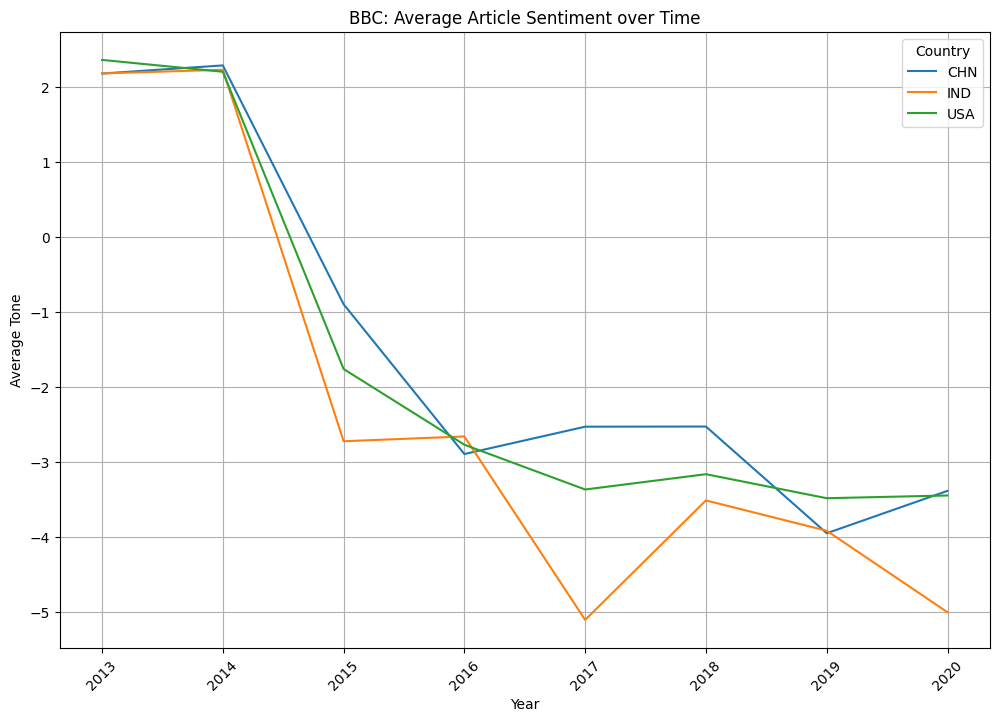

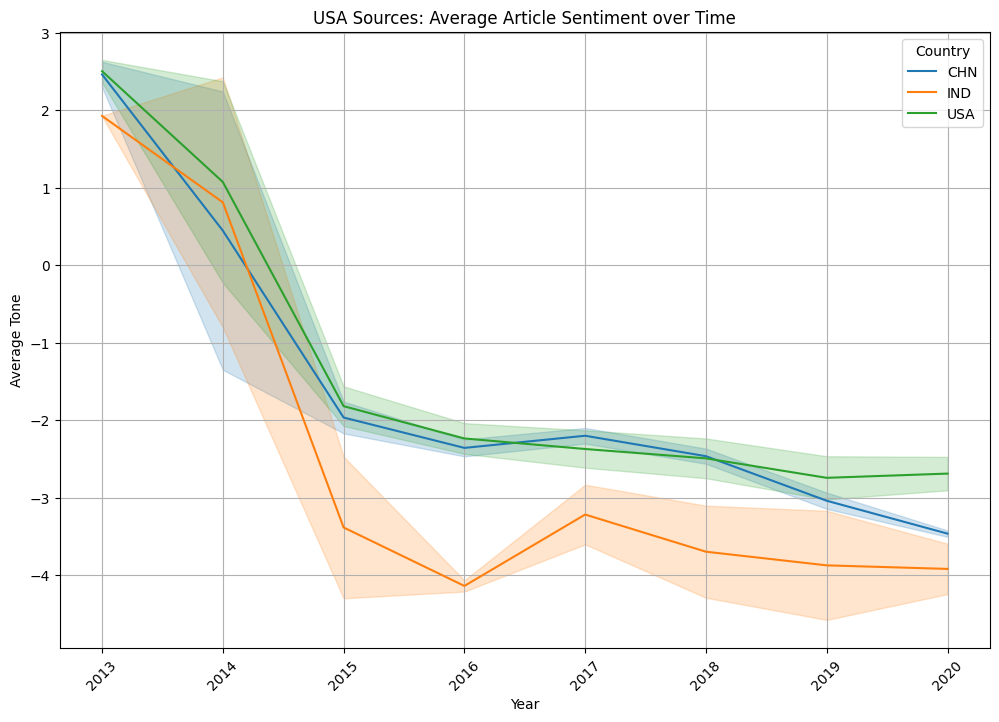

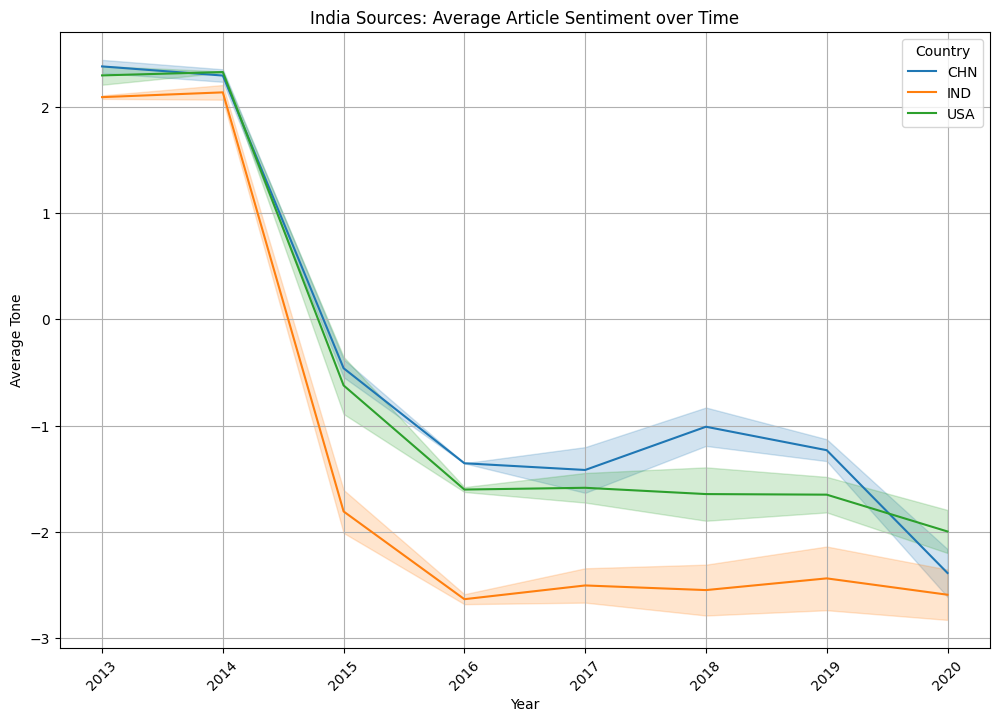

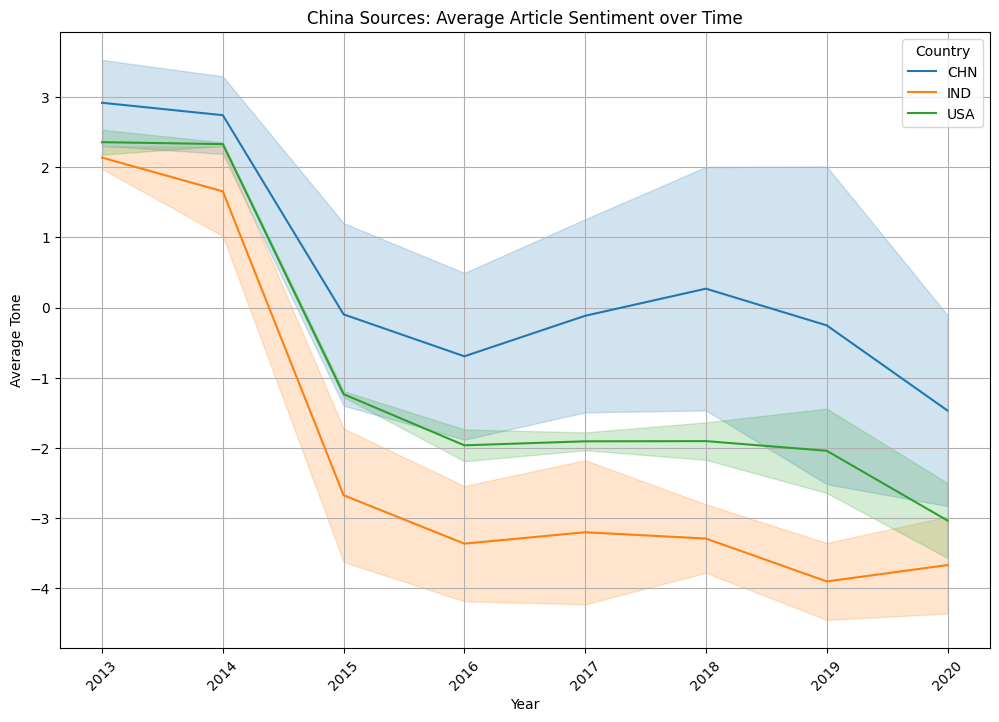

In [70]:
# Find the Average Tone of articles for each country for each year per source country
df_avg_tone_bbc = df_bbc.groupby(['YEAR', 'Actor1CountryCode', 'Source'])['AvgTone'].mean().reset_index()
df_avg_tone_usa = df_usa.groupby(['YEAR', 'Actor1CountryCode', 'Source'])['AvgTone'].mean().reset_index()
df_avg_tone_india = df_india.groupby(['YEAR', 'Actor1CountryCode', 'Source'])['AvgTone'].mean().reset_index()
df_avg_tone_china = df_china.groupby(['YEAR', 'Actor1CountryCode', 'Source'])['AvgTone'].mean().reset_index()

# Plot the Average Tone of articles for each country for each year per source country
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_avg_tone_bbc, x='YEAR', y='AvgTone', hue='Actor1CountryCode', markers=True)
plt.title('BBC: Average Article Sentiment over Time')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_avg_tone_usa, x='YEAR', y='AvgTone', hue='Actor1CountryCode', markers=True)
plt.title('USA Sources: Average Article Sentiment over Time')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_avg_tone_india, x='YEAR', y='AvgTone', hue='Actor1CountryCode', markers=True)
plt.title('India Sources: Average Article Sentiment over Time')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_avg_tone_china, x='YEAR', y='AvgTone', hue='Actor1CountryCode', markers=True)
plt.title('China Sources: Average Article Sentiment over Time')
plt.xlabel('Year')
plt.ylabel('Average Tone')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.grid(True)
plt.show()


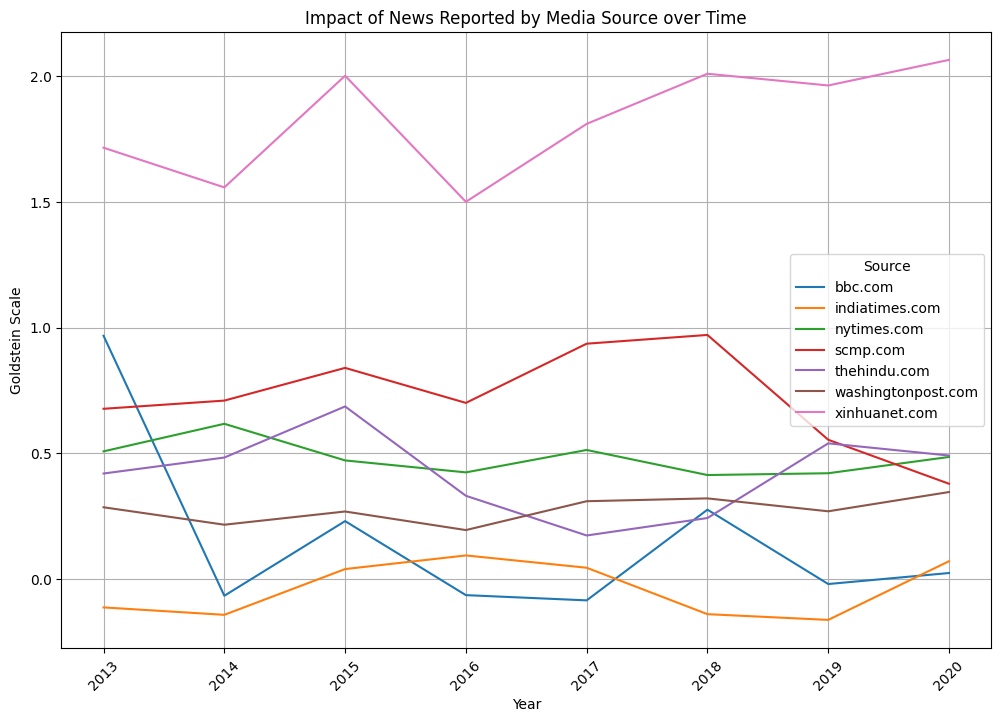

In [83]:
# Find the impact of news reported by each media source
df_impact_Source = df.groupby(['YEAR', 'Source'])['GoldsteinScale'].mean().reset_index()

# Plot the impact of news reported by each media source over time
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_impact_Source, x='YEAR', y='GoldsteinScale', hue='Source', markers=True)
plt.title('Impact of News Reported by Media Source over Time')
plt.xlabel('Year')
plt.ylabel('Goldstein Scale')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.show()

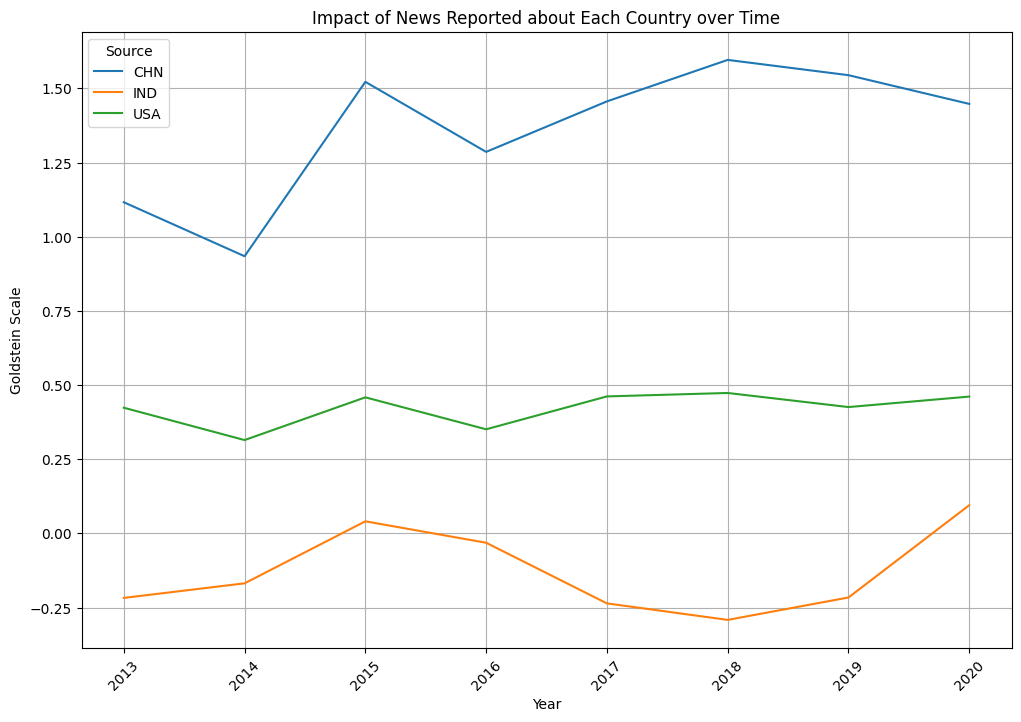

In [84]:
# Find the impact of news reported by each media source
df_impact_Actor = df.groupby(['YEAR', 'Actor1CountryCode'])['GoldsteinScale'].mean().reset_index()

# Plot the impact of news reported by each media source over time
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_impact_Actor, x='YEAR', y='GoldsteinScale', hue='Actor1CountryCode', markers=True)
plt.title('Impact of News Reported about Each Country over Time')
plt.xlabel('Year')
plt.ylabel('Goldstein Scale')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.show()

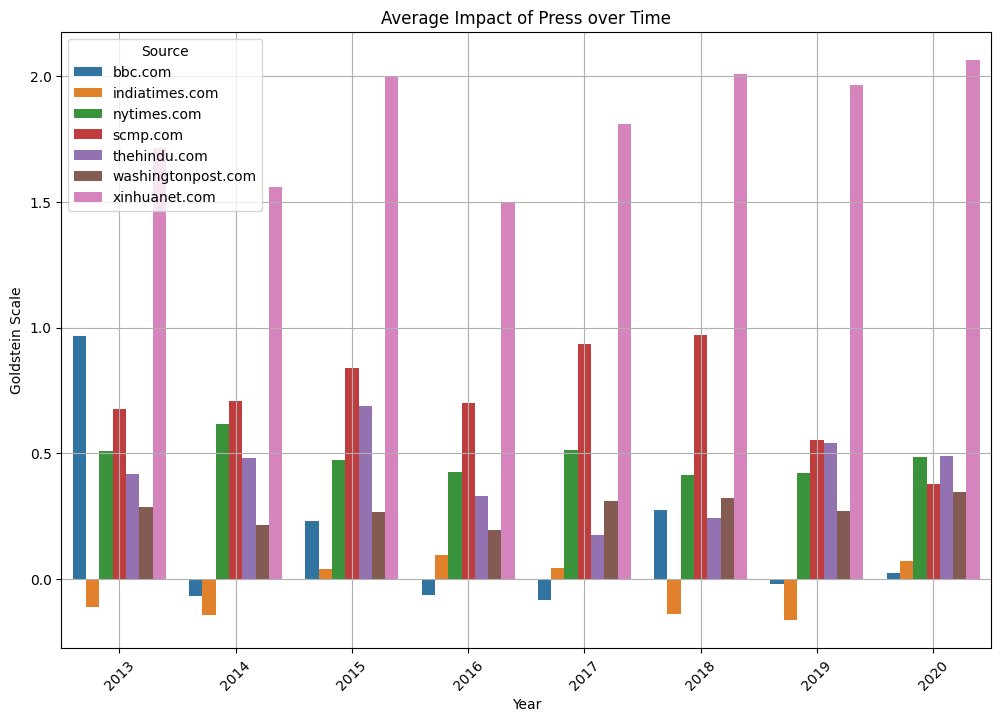

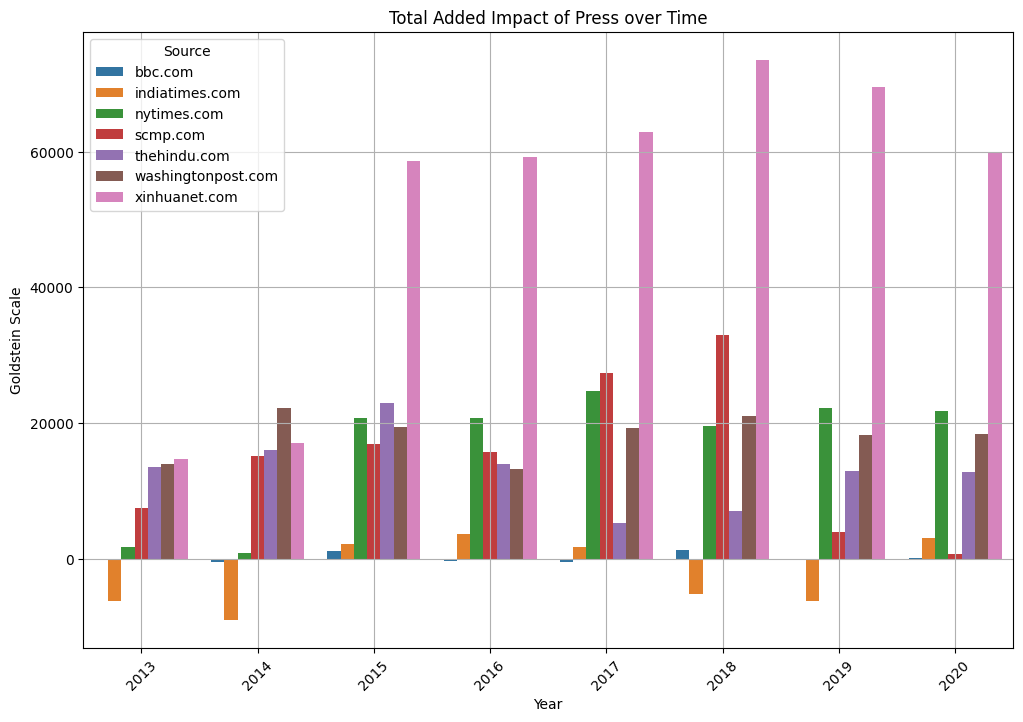

In [89]:
# Graph Average impact of press over time with a bar graph for each year add a different color for each source
df_impact = df.groupby(['YEAR', 'Source'])['GoldsteinScale'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=df_impact, x='YEAR', y='GoldsteinScale', hue='Source')
plt.title('Average Impact of Press over Time')
plt.xlabel('Year')
plt.ylabel('Goldstein Scale')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.show()

# Graph Total impact of press over time with a bar graph for each year add a different color for each source
df_impact = df.groupby(['YEAR', 'Source'])['GoldsteinScale'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=df_impact, x='YEAR', y='GoldsteinScale', hue='Source')
plt.title('Total Added Impact of Press over Time')
plt.xlabel('Year')
plt.ylabel('Goldstein Scale')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.grid(True)
plt.show()